In [1]:
from IPython.display import display, HTML
from datetime import datetime

# Define the notebook title
Notebook_title = "scRNA Lethal COVID19 Analysis"

# Get the current date
current_date = datetime.now().strftime("%B %d, %Y")

# Create the HTML string with title, date, and author
html_content = f"""
<h1 style="text-align:center;">{Notebook_title}</h1>
<br/>
<h3 style="text-align:left;">MikiasHWT</h3>
<h3 style="text-align:left;">{current_date}</h3>
"""

# Display the HTML content in the output
display(HTML(html_content))


# Background
As of November 2024, the [World health Organization](https://data.who.int/dashboards/covid19/cases) reported 777 million (103 million in the US) confirmed cases of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) worldwide, with over 7 million deaths (1.2 million in the US). This coronavirus, commonly known as COVID-19, has had a profound impact on global health, economies, and societies.In this project, I aim to replicate the analyses from the paper ["A molecular single-cell lung atlas of lethal COVID-19"](https://www.nature.com/articles/s41586-021-03569-1#data-availability), [DOI: 10.1038/s41586-021-03569-1](https://doi.org/10.1038/s41586-021-03569-1). 

The original paper provides an in-depth examination of the cellular and molecular alterations in the lungs of individuals who died of COVID-19, utilizing single-nucleus RNA sequencing to analyze lung tissue from 19 patients (12M, 7F, mediage age 72) who died of COVID-19 and biopsy or resection samples from 7 pre-pandemic controls (4M, 3F, median age 70).

## Objectives
By replicating the various analyses performed by the original authors, I intend to recapitulate the original findings and further explore the pathophysiology of lethal COVID-19. 

This will include:
- Process single-cell RNA sequencing data using sensible quality control metrics.
- Cluster and integrate immune cell populations between healthy and COVID-19 samples. 
- Identify and label immune cell using gene expression profiles and activation states
- Characterize differences in cell infilitration, proportions and activation states between healthy and COVID-19 samples. 

The ultimate goal of this project is to enhance my understanding of the cellular and molecular mechanisms underlying severe COVID-19.

# Data Source
The data was made publicly avaible in Gene Expression Omnibus, under [GSE171524](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524). 
I have downloaded the TAR file to a local folder and extracted the CSV files containing the data usuing 7-Zip. 

## Tissue Collection
Tissue samples from lethal COVID-19 patients were collected with consent, from New York Presbyterian Hospital or Columbia University Medical Center. Samples were tested for COVID-19 using reverse transcription quantitative polymerace chain reaction (RT-qPCR) and the regions of interest were selected based on pathological review of adjecent Haematoxylin and Eosin (H&E) stained, Formalin-Fixed Parafin-Embedded (FFPE) slides. 1 cm^3 samples were snap frozen in liquid nitrogen, and embedded in Optimal Cutting Temperature (OCT) compound in -80C freezers until processing. 

## Tissue Processing
In preperation for single-nucleus RNA sequencing tissues were: 
- Rinced of OCT in ice-cold Phosphate Buffered Saline (PBS).
- Mechanically dissociated with fine scissors and pipettes in a buffer containing Tween surfactant (and RNase Inhibitor) to aid in dissociation of cells and extraction of nuclei. 
- Washed in Tris salt containing buffer and filetered with 70um cell strainers followed by pelleting at 500g and resuspension in an appropriate amount of Tris buffered solution. 
- Cells were counted by secondary investigator uninvoled with tissue processing before 15,000-20,000 nuclei were loaded per channel on a Chromium controller using Chromium Next GEM Single Cell 3ʹ v3.1 reagents. 


## Library Preparation & Sequencing 

Chromium Next GEM Single Cell 3ʹ v3.1 reagents were used to prepare single-nucleus RNA-seq libraries, mostly according to manufacturers recomendation. One additional cDNA amplificiation cycle was included to account for lower RNA yields from nuclei as compared to whole-cell RNA extractions. RNA libraries and cDNA were quantified using D1000 TapeStation and Qubit HS DNA quantification kit. Finally the libraries were pooled in an equimolar mixture and sequenced on a NovaSeq 6000 with S4 flow cell, usuing paired-end, single-index sequencing.

## Data Preprocessing

- Raw 3' scRNA-seq data was demultiplexed using Cell Ranger (v5.0).
- Trancripts were alligned using a COVID-19 appended human reference genome (GRCh38).
- Ambient RNA was removed using CellBender (v.0.2.0). 
- Expression matrices were procused using Seurat (v.3.2.3). 
- The following filters were applied to keep nuclei with:
    - 200-7500 genes. 
    - 400-40,000 Unique Molecular Idenitifier(UMI's).
    - <10% Mitochondrial reads. 
- Scrublet was applied with a predicted rate of 4-9.6% to remove nuclei doublets.  

# Prep Workplace

## Import Libraries

In [2]:
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
import scanpy as sc  # Single-cell data analysis
import scvi  # Single-cell variational inference for modeling
from scipy.stats import median_abs_deviation  # Robust statistic for dispersion
import os  # Operating system interface

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
c:

## Directories

In [3]:
# Define directories 
datDir = os.path.abspath("data")
outDir = os.path.abspath("output")

# List their contents. 
for path in [datDir, outDir]:
    # os.makedirs(path, exist_ok=True)   # Optional: Create directories if they dont exist
    print(f"Contents of {path}:")
    print("\n".join(os.listdir(path)) or "Directory is empty", "\n")

Contents of c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\data:
GSE171524_RAW
GSE171524_RAW.tar
ref
Supplementary_Table1_Clinical_Information.xlsx 

Contents of c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\output:
Directory is empty 



# Import Data

The original authors utilized R programming and Seurat package to analyze and prepare their data. This requires some consideration as we import data processed in R into an Python envirnment, as Seurat sets genes as the rows and cells as the columns while Scanpy reverses this orientation. This can be resolved by transposing the CSV files as we import them. 

In [4]:
# Read csv files into Anndata object
adata = sc.read_csv("data/GSE171524_RAW/csv/GSM5226574_C51ctr_raw_counts.csv").T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [5]:
print(f"This sample has {adata.X.shape[0]} cells and {adata.X.shape[1]} transcripts")

This sample has 6099 cells and 34546 transcripts


In [6]:
# View cell barcodes
adata.obs 

""
TAGGTACCATGGCCAC-1_1
ATTCACTGTAACAGGC-1_1
TAACTTCCAACCACGC-1_1
TTGGGTACACGACAAG-1_1
AGGCCACAGAGTCACG-1_1
...
CGCCATTGTTTGCCGG-1_1
CACTGGGGTCTACGTA-1_1
CATACTTGTAGAGGAA-1_1
TTTGGTTTCCACGGAC-1_1


In [7]:
# View transcripts (genes)
adata.var

""
AL627309.1
AL627309.5
AL627309.4
AL669831.2
LINC01409
...
VN1R2
AL031676.1
SMIM34A
AL050402.1


In [8]:
# View count matrix
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Quality Control
Unlike Bulk RNA sequencing, single cell RNA sequencing results in far fewer data points, leading to an excessive number of zero's in the count matrix. In addition, the requirement to isolate each cell or nuclei into its own sequencing bead can be difficult to acomplish especially for stromal tissues like epithelial cell and adherent immune cells such as myeloid cells. Not to mention that many cell types such as Neutrophils are infamous for low RNA quanitity and high sensitivity to processing steps. 

In essence, before we receive data in a count matrix, many considerations must be given to prevent biases in processing. Once the cells have been sequenced, additional consideration must be given to ensure that the appropriate quality control metrics are applied according to processing steps, cells and tissues of interest as well as the scientific question at hand. 

The original authors performed various quality control methods to filter out low quality reads and doublets. For the sake of posterity, I will inspect the quality of these sample and set additional QC metrics where neccesary. 

The standard approach for quality control of scRNA data requies that we inspect the following metrics. 
- The number of counts per barcode (count depth)
- The number of genes per barcode
- The fraction of counts from mitochondrial genes per barcode

It is generally recomended to be permissive while filtering cells as to avoid eliminating viable populations. 

## Objective
By exploring the data and applying QC metrics I aim to:

- Remove reads from nuclei extracted from dead or dying cells. 
- Remove reads from empty droplets. 
- Remove reads from droplets with more than one nuclei. 
- Remove reads containing contaminating/ambient RNA.


Following this section we will have the following metrics for quality control. 

**Gene Metrics:** 
- `n_cells_by_counts`: The number of cells in which a given gene (feature) is expressed.
    - Identifies whether a gene is highly or lowly expressed.

- `mean_counts`: The mean expression of a gene across all cells.

- `log1p_mean_counts`: The pseudo logarithm (1+count) of mean_counts.
    - Used for visualization or comparison when data ranges are large.

- `pct_dropout_by_counts`: The percentage of cells in which a given gene has zero expression.
    - Identifies genes that are rarely expressed and may not be informative.

**Cell Metrics:** 
- `n_genes_by_counts`: The number of genes with non-zero expression in each cell.
    - Indicates the diversity of gene expression in a cell and is commonly used to filter low-quality cells.
    
- `total_counts`: The total number of counts (sum of all gene expressions) for each cell.
    - Reflects library size or sequencing depth and is used to identify cells with abnormal counts.

- `pct_counts_in_top_20_genes`: The percentage of total counts contributed by the top 20 most highly expressed genes.
    - Identifies cells dominated by a small number of genes, which can indicate low quality or cell-specific biological properties.

**Mitochondrial Gene Metrics:**
- `total_counts_mt`: The total counts from mitochondrial genes for each cell.
    - Indicates the mitochondrial content in a cell, often used as a proxy for cell health.

- `pct_counts_mt`: The percentage of total counts from mitochondrial genes.

**Ribosomal Gene Metrics:**
- `total_counts_ribo`: The total counts from ribosomal genes for each cell.
    - Indicates ribosomal RNA expression, which may identify cells in various stages of replication.
    - Depending on question at hand, it may be beneficial to threshold using this metric. 

- `pct_counts_ribo`: The percentage of total counts from ribosomal genes.

**Hemoglobin Gene Metrics:**
- `total_counts_hb`: The total counts from hemoglobin genes for each cell.
    - High expression could indicate improper red cell removal during processing.
    - Depending on the question at hand, it may be useful to remove red cell contamination. Alternively, red blood cells can be used to verify if clustering is being performed correctly.  

- `pct_counts_hb`: The percentage of total counts from hemoglobin genes.

## Create QC Metrics

In [9]:
# Define variables to idenitify known gene subsets
# mitochondrial genes ("MT-"" for human, "mt-" for mouse)
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [10]:
# Calculate QC metrics using scanpy function
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=["mt", "ribo", "hb"], 
    inplace=True, 
    percent_top=[20], # finds cumulative precentage of total counts produced by top 20 expressed genes
    log1p=True
)
adata

AnnData object with n_obs × n_vars = 6099 × 34546
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [11]:
# View newly added transcript variables
adata.var.head()

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
AL627309.1,False,False,False,8,0.001312,0.001311,99.868831,8.0,2.197225
AL627309.5,False,False,False,33,0.005411,0.005396,99.458928,33.0,3.526361
AL627309.4,False,False,False,4,0.000656,0.000656,99.934415,4.0,1.609438
AL669831.2,False,False,False,2,0.000328,0.000328,99.967208,2.0,1.098612
LINC01409,False,False,False,274,0.048697,0.047548,95.507460,297.0,5.697093


In [12]:
# View statistical distribution of qc metrics
adata.var.describe()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
count,34546.000000,34546.000000,34546.000000,34546.000000,34546.000000,34546.000000
mean,169.821976,0.044760,0.036900,97.215577,272.993835,3.192600
std,371.595219,0.393763,0.094716,6.092724,2401.563232,2.390199
min,0.000000,0.000000,0.000000,0.147565,0.000000,0.000000
25%,2.000000,0.000328,0.000328,97.556977,2.000000,1.098612
50%,19.000000,0.003443,0.003437,99.688474,21.000000,3.091043
75%,149.000000,0.027873,0.027492,99.967208,170.000000,5.141664
max,6090.000000,69.016563,4.248732,100.000000,420932.000000,12.950229


In [13]:
# View newly added cell variables
adata.obs.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb
TAGGTACCATGGCCAC-1_1,6764,8.819518,24256.0,10.096460,8.381431,153.0,5.036952,0.630772,78.0,4.369448,0.321570,1.0,0.693147,0.004123
ATTCACTGTAACAGGC-1_1,6686,8.807921,19020.0,9.853299,8.175605,404.0,6.003887,2.124080,137.0,4.927254,0.720294,1.0,0.693147,0.005258
TAACTTCCAACCACGC-1_1,5158,8.548498,15645.0,9.657970,10.450623,221.0,5.402678,1.412592,231.0,5.446737,1.476510,0.0,0.000000,0.000000
TTGGGTACACGACAAG-1_1,4900,8.497195,15220.0,9.630431,9.290407,3.0,1.386294,0.019711,10.0,2.397895,0.065703,0.0,0.000000,0.000000
AGGCCACAGAGTCACG-1_1,5544,8.620652,13217.0,9.489335,7.687070,417.0,6.035481,3.155028,96.0,4.574711,0.726337,0.0,0.000000,0.000000


In [14]:
# View statistical distribution of qc metrics
adata.obs.describe()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb
count,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000,6099.000000
mean,961.906870,6.726092,1546.293701,7.112249,14.838525,11.416790,1.135443,0.625995,3.009182,1.029693,0.189550,0.116740,0.075665,0.008029
std,568.855438,0.526026,1271.902588,0.655411,3.662213,37.603889,1.412402,1.312256,6.499735,0.768085,0.259934,0.383935,0.233103,0.031268
min,276.000000,5.624018,401.000000,5.996452,5.848624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,557.500000,6.325254,734.000000,6.599871,12.429076,0.000000,0.000000,0.000000,1.000000,0.693147,0.049776,0.000000,0.000000,0.000000
50%,804.000000,6.690842,1139.000000,7.038784,14.198606,1.000000,0.693147,0.054127,2.000000,1.098612,0.145349,0.000000,0.000000,0.000000
75%,1219.000000,7.106606,1953.500000,7.577890,16.594828,6.000000,1.945910,0.603502,4.000000,1.609438,0.246812,0.000000,0.000000,0.000000
max,6764.000000,8.819518,24256.000000,10.096460,47.761194,627.000000,6.442540,9.828118,231.000000,5.446737,6.219313,8.000000,2.197225,0.493827


Using the describe functions we can get a high level overview of the QC metrics. 
We note that the QC metrics applied by authors in the preprossing steps are present by inspecting the max and min value of `total_counts`, `n_genes_by_counts` and `pct_count_mt`. 

We will visualize a subset of the newly defined QC metrics in case there is anything else of note. Specifically we will inspect the plots for any obvious signs of outliers. 

## Visualize QC Metrics

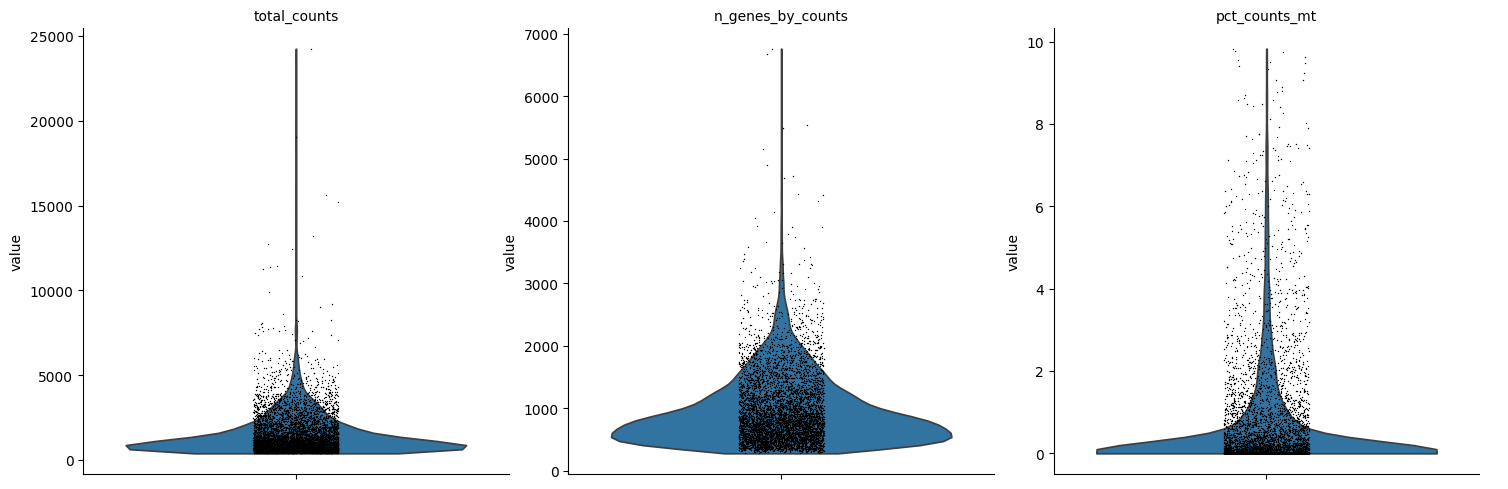

In [15]:
# total count = total transcripts (UMI's) per cell (defined in preprossesing to be between 400-40,000)
# n_genes_by_counts = number of unique genes per cell (defined in preprosession to be between 200-7500)
# pct_counts_mt = percent of mitochondrial genes per cell
sc.pl.violin(
    adata,
    keys=["total_counts", "n_genes_by_counts","pct_counts_mt"],
    groupby=None,
    multi_panel=True
)

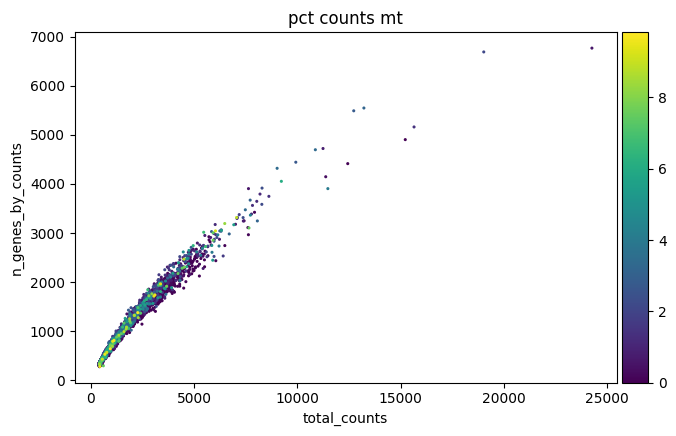

In [16]:
# Plot total transcripts by unique genes & color by percent mitrochondrial genes per cell
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Apply QC Metrics

Quality control of data is often an itterative process that consumes a vast majority of an analysis lifecycle. It requires careful considerations of the known, the unknown and the unknown-unknown. In essence, we can never truly claim to have "finished" cleaning data, especially in Biology where the data's inherent noise is nearly impossible to seperate from technical noise produced by our method of data collection. 

In this particular case, the data does not appear overly problematic upon initial inspection. Yet for the sake of exploration we will consider a thresholding methodology to detect outliers using the median values of our QC metrics (keeping in mind that a second round of QC may result in the elimination of valid populations of interest). Using [Germain et al., 2020](https://doi.org/10.1186/s13059-020-02136-7) as reference, we will define an outlier as any data point that lies beyond k Median Absolute Deviations (MAD) from the median. The MAD is a robust measure of variability, calculated as the median of the absolute deviations from the dataset's median. Using the `median_abs_deviation` function from `scipy.stats`, we will compute the MAD and establish thresholds to identify outliers. For this implementation, we will use k=5k=5 as the multiplier.


Median Absolute Deviation is defined as:
$$
\text{MAD} = \text{median} \left( \lvert X_i - \text{median}(X) \rvert \right)
$$


Where
$
X_i
$
is the respective QC metric for a given cell.


In [17]:
# Create MAD function
def is_outlier(adata, qcmetric: str, madunits: int):
    """
    Identified outlier points using the Mean Absolute Deviation function from scipy

    Args:
        adata (_type_): Anndata object with RNA data
        qcmetric (str): QC metric to use for outlier detection
        madunits (int): Value of MAD units to use for the QC metric

    Returns:
        _type_: Boolean value identifying outliers
    """
    M = adata.obs[qcmetric]
    outlier = (M < np.median(M) - madunits * median_abs_deviation(M)) | (M > np.median(M) + madunits * median_abs_deviation(M))
    return outlier


In order to select our QC metrics for outlier detection, i would like to explore the impact of using raw values versus log transformed values. We will define a plotting function to visualize the cutoff threshold using 5 MAD's on a histogram. 

In [18]:

def plot_histograms_with_MAD(adata, obs1, obs2, madunits, bins=100):
    """
    Plots two histograms side by side with their means & 5 MAD's labeled 

    Args:
        adata (AnnData): The dataset containing the variables to plot.
        obs1 (str): The name of the first variable to plot.
        obs2 (str): The name of the second variable to plot.
        bins (int): Number of bins to use in the histograms. Default is 100.
        mad_units (int): Number of MAD units for outlier detection.

    Returns:
        None: Displays the plots.
    """

    # Prepare subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for ax, obs in zip(axes, [obs1, obs2]):
        data = adata.obs[obs]
        median_val = np.median(data)

        # Apply "is_outlier" function
        outliers = is_outlier(adata, obs, madunits)

        # Plot histograms
        sns.histplot(data, bins=bins, ax=ax, kde=False)
        upper_threshold = np.median(data) + madunits * median_abs_deviation(data)
        ax.axvline(upper_threshold, color="red", linestyle="--", label=f"{madunits} MADs: {upper_threshold:.2f}")

        # Median line
        ax.axvline(median_val, color="orange", linestyle="-", label=f"Median: {median_val:.2f}")

        # Titles and labels
        ax.set_title(f"Distribution of {obs}")
        ax.set_xlabel(obs)
        ax.set_ylabel("Frequency")
        ax.legend()

    # Adjust layout and show
    plt.tight_layout()
    plt.show()


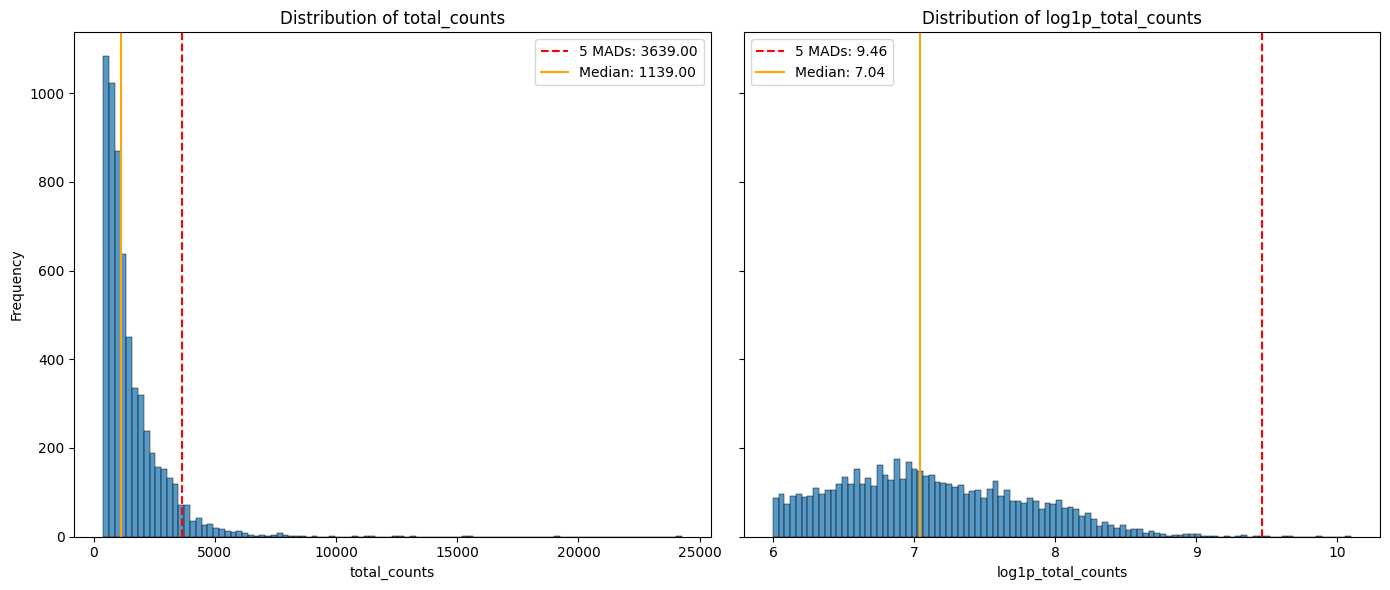

In [19]:
# Plot total transcript counts by log transformed total transcripts
plot_histograms_with_MAD(adata, "total_counts", "log1p_total_counts", madunits=5)

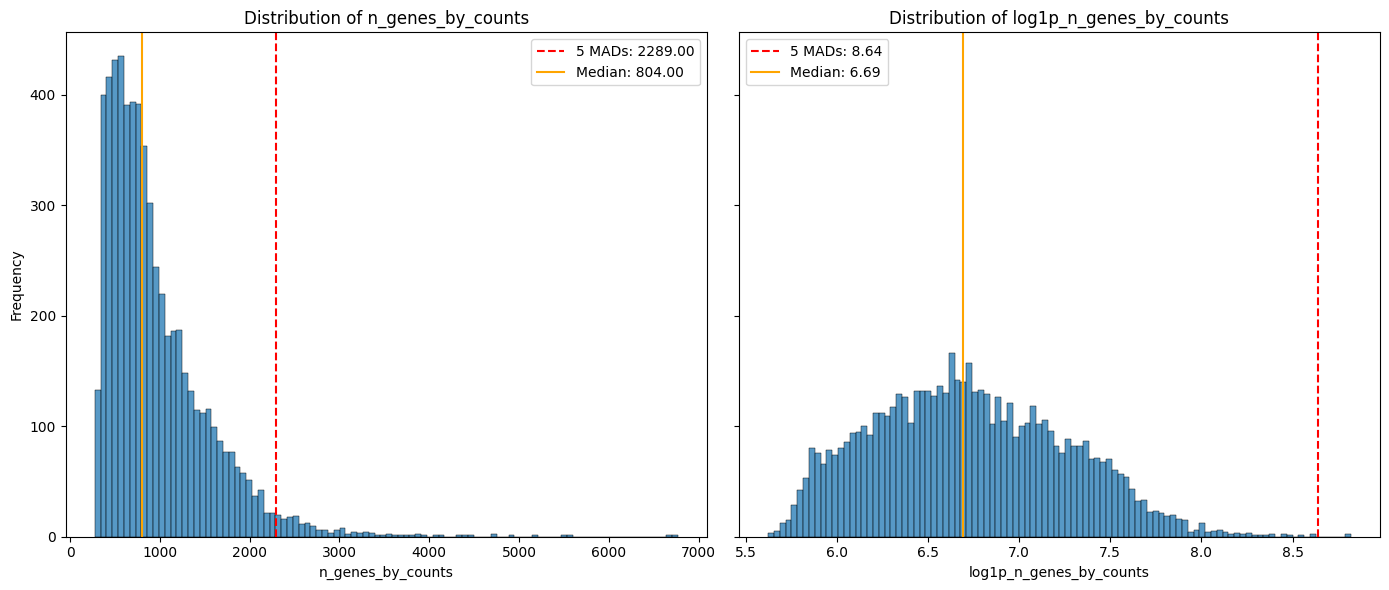

In [20]:
# Plot unique gene counts by log transformed values of the same
plot_histograms_with_MAD(adata, "n_genes_by_counts", "log1p_n_genes_by_counts", madunits=5)

We note that using raw counts for outlier detection will result in a high number of cells being eliminated. Additionally, the use of raw counts does not properly account for the skewness of RNA data, while log transformed values will likely allow for a better representation of the overall data with a more representative median that is less impacted by strong outlier cells. 

Additionally, we can apply the `is_outlier` function to both log transformed and log transformed values to get a count of the number of cells that would be identified as outliers. 

In [21]:
# Outlier detection using log transformed values
log_outliers = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
)

# using count values
raw_outliers = (
    is_outlier(adata, "total_counts", 5)
    | is_outlier(adata, "n_genes_by_counts", 5)
)

print(f"Using raw values results in: {raw_outliers.sum()} outliers.\nWhile log transformed values result in: {log_outliers.sum()} outliers. ")

Using raw values results in: 351 outliers.
While log transformed values result in: 5 outliers. 


I will move forward with log transformed values to keep in line with "permissive filtering".

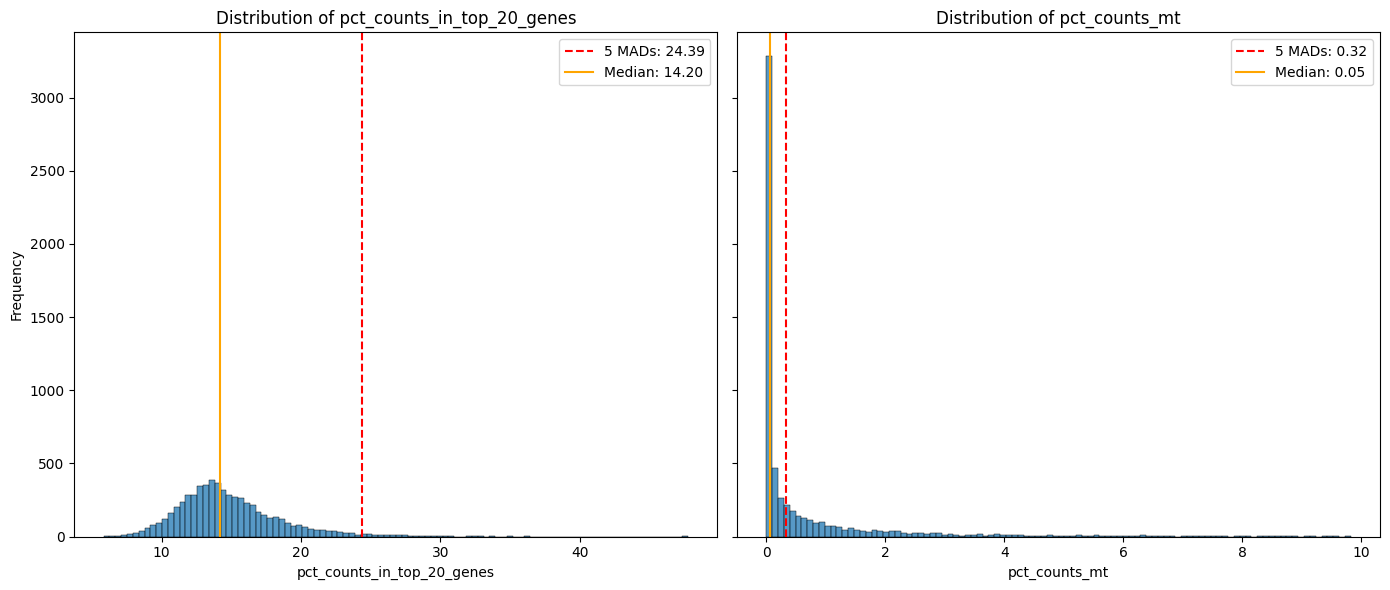

In [22]:
# Plot unique gene counts by log transformed values of the same
plot_histograms_with_MAD(adata, "pct_counts_in_top_20_genes", "pct_counts_mt", madunits=5)

In [23]:
# using count values
top20_outliers = (
    is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)

mt_outliers = (
    is_outlier(adata, "pct_counts_mt", 5)
)

print(f"Top 20 genes metric results in: {top20_outliers.sum()} outliers")

print(f"Mitochondrial gene precentage metric results in: {mt_outliers.sum()} outliers")

Top 20 genes metric results in: 133 outliers
Mitochondrial gene precentage metric results in: 2008 outliers


`pct_counts_in_top_20_genes` is describes as percentage of total counts contributed by the top 20 most highly expressed genes in a given cell. This metric results in a large number of outliers being detected. These could be true positive or true negative detections. 

In the case that the outliers are correctly identified, our data could benefit from removing those cells as they are heavily dominated by a small subset of genes. 

Alternitevly, we could erroniously eliminate real biologically relevant cells that naturally express a small subset of genes (such as plasma cells, who'se major role is antibody production)

We will leave this consideration for a second round of QC, and allow these 133 cells into the analysis for now. 

The result is even more significant for mitochondrial gene presentage as a qc metric

In [24]:
# Outlier detection usuing log transformed values
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
)

adata.obs.outlier.value_counts()

outlier
False    6094
True        5
Name: count, dtype: int64

In [25]:
# cast boolean value to category for plotting
adata.obs["cat_outlier"] = adata.obs["outlier"].astype("category")

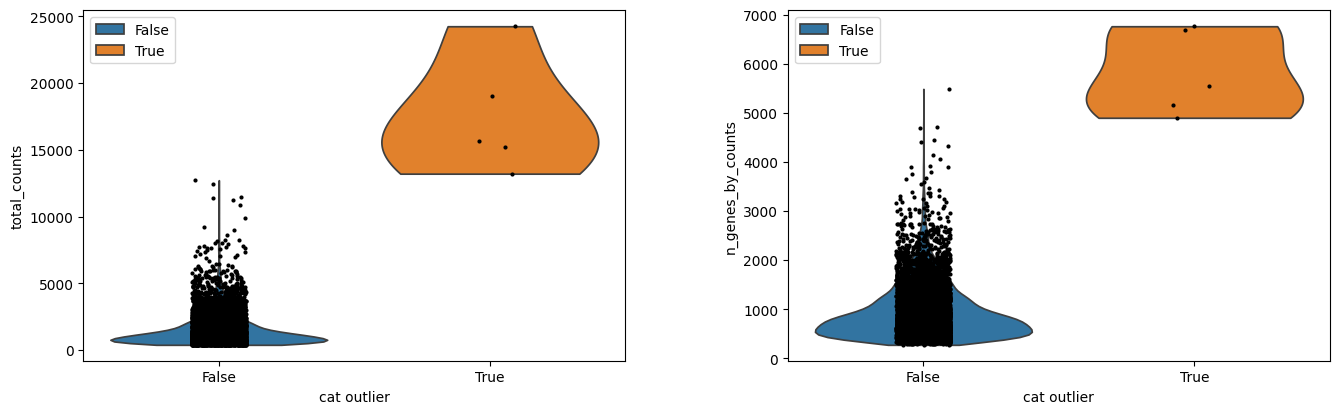

In [26]:
# Show outliers on violin plot
sc.pl.violin(
    adata,
    keys=["total_counts", "n_genes_by_counts"],
    size=3,
    groupby="cat_outlier",
    multi_panel=True
)

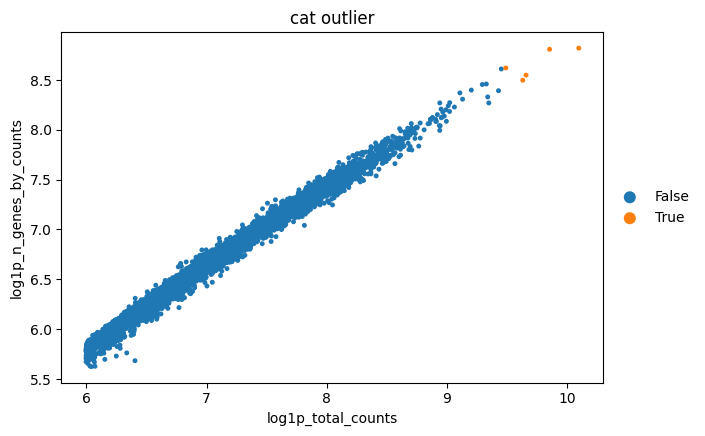

In [27]:
sc.pl.scatter(adata, "log1p_total_counts", "log1p_n_genes_by_counts", size=50, color="cat_outlier")

## Gene based QC
In addition to QC metrics applied to filter out uninformative cells, we want to remove genes that are not expressed in enough cells to be useful for analysis. 

In [28]:
# Count genes with no expression in any cells
print("Zero-variance genes pre-filtering:", np.sum(adata.X.var(axis=0) == 0))

Zero-variance genes pre-filtering: 5666


In [29]:
# Keep genes expressed in at least one cell
sc.pp.filter_genes(adata, min_cells=1)

In [30]:
# Check filerting results
print("Zero-variance genes post-filtering:", np.sum(adata.X.var(axis=0) == 0))

Zero-variance genes post-filtering: 0


## Filter Data

Keeping in mind that we will likely return to this choice of QC application, we can move forward with out chosen threshold and filter out data. 

Apply ambient RNA detection methods
- SoupX [Young and Behjati, 2020](https://doi.org/10.1093/gigascience/giaa151) (required raw feature data)
- DecontX [Yang et al., 2020](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1950-6) 

Apply doubled detection method
- scDblFinder [Xi and Li, 2021](https://www.sciencedirect.com/science/article/pii/S2666166721004068?via%3Dihub)

In [31]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 6099
Number of cells after filtering of low quality cells: 6094


# Normalization

The process of RNA sequencing involves many steps that introduce bias into our counts data. 

- Technican variability: Two identical cells can have highly different counts for any given gene due to differences in processing, reverse transcription, amplificiation and sequencing steps. This results in two cells that for all intents and purposes are identical, appearing to have biologically relevant differences in gene signatures. The use of Unique Molecular Identifiers help reduce the technical noise produced during PCR, but cannot account for other steps of variability production.  

- Gene size variability: Larger genes will have more sequencing targets than smaller genes and may appear to have higher expression because of that fact. 

- Mean-Variance: The ground truth of RNA amplification has long been considered to fall along a logrithmic distribution, specifically a log 2 transformation. The reality is in fact convoluded by various factors such as feedback loops, signaling pathways, environmental factors, selective inhibition, and transcriptional bursts. As such, log based normalization methods cannot perfectly account for over dispersian of RNA expression. A Poisson based model with a Gamma scaling facor has been discovered to better fit RNA expression varibility.

- Downstream Statistics: Lastly, many downstream analysis methodologies require normalized data in order to apply statistical methods. These include but are not limited to Clustering and dimensionality reduction, differential gene expression and pathway analyses. (Some pipelines may require raw data in order to apply their own normalization methods)

Various normalization methods can be applied to data and much like the quality control portion of our workflow, data normalization requires careful consideration of the question at hand as well as an idea of what downstream analyses will be used. 

For our case we will apply an analytic approximation of Pearson residuals. [Normalization and variance stabilization of single-cell RNA-seq data using regularized negative binomial regression](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)

In [32]:
from scipy.sparse import csr_matrix # Stores and operates on sparse matrices

In [33]:
# !!! not sure why this is required, but something is happening one of the previous code cells that nessesitates rerunning this code. 
sc.pp.filter_genes(adata, min_cells=1)

# Compute Pearsons residuals and add normalized sparse matrix as adata layer
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["pearson_residuals"] = csr_matrix(analytic_pearson["X"])

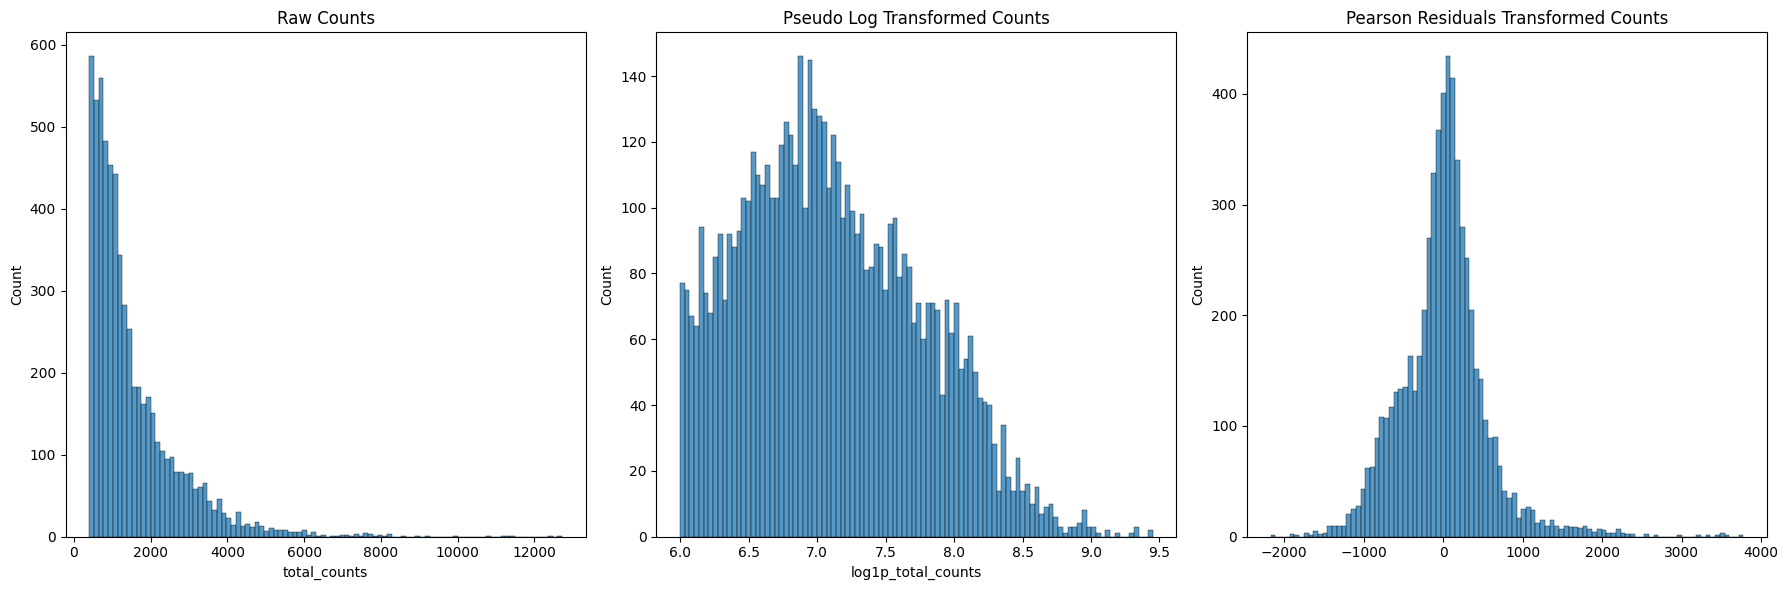

In [34]:
# Plot histograms
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  

# Raw Counts Histogram
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=ax[0])
ax[0].set_title("Raw Counts")

# Log-Transformed Counts Histogram
sns.histplot(adata.obs["log1p_total_counts"], bins=100, kde=False, ax=ax[1])
ax[1].set_title("Pseudo Log Transformed Counts")

# Pearson Residuals Histogram (convert sparse matrix to dense with .A1)
sns.histplot(adata.layers["pearson_residuals"].sum(1).A1, bins=100, kde=False, ax=ax[2]) 
ax[2].set_title("Pearson Residuals Transformed Counts")

# Display 
plt.tight_layout()  
plt.show();


# Feature Selection

Much of RNA sequencing data is actually quite uninformative in nature. Many genes are comparably expressed between many cell types under homeostatic conditions, these housekeeping genes do not add value to a final analysis (although they can provide a lot of benefit for quality assesement). Additionally most RNA sequencing experiments are targetted at specific tissues or cell types, meaning that certain gene signatures provide little insight of value. In a perfect world where computational costs were not a consideration, it may be interested to use all 20-30,000 genes of a typical single cell experiment for downstream analysis, but in reality this is not feasable when a single sample can contain thousands of cells with many samples in an experiment. 

Therefor it is standard practice to subset our genes for the most variably expressed genes. Not simply for the genes that are highly expressed, as this could include housekeeping genes like Beta Acting and GAPDH, but genes that have a high degree of variablity between cell types. These genes are generally considered to be the informative signatures worth keeping for downstream analysis. 

Once again, various methods exist for applying this selection criteria. 
- For now, we will use Scanpy's `sc.pp.highly_variable_genes` with Seurat modification [Comprehensive Integration of Single-Cell Data](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867419305598%3Fshowall%3Dtrue)
- An alternate method we will try in the future uses deviance method to rank genes [Feature selection and dimension reduction for single-cell RNA-Seq based on a multinomial model](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)

In [35]:
adata

AnnData object with n_obs × n_vars = 6094 × 28843
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'cat_outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cat_outlier_colors'
    layers: 'pearson_residuals'

In [36]:
# Select top 200 highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')

In [37]:
adata.var

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
AL627309.1,False,False,False,8,0.001312,0.001311,99.868831,8.0,2.197225,8,False,NaN,0.001313,0.001311,0.939811
AL627309.5,False,False,False,33,0.005411,0.005396,99.458928,33.0,3.526361,33,False,NaN,0.005415,0.005387,0.871643
AL627309.4,False,False,False,4,0.000656,0.000656,99.934415,4.0,1.609438,4,False,NaN,0.000656,0.000656,0.964780
AL669831.2,False,False,False,2,0.000328,0.000328,99.967208,2.0,1.098612,2,False,NaN,0.000328,0.000328,0.986353
LINC01409,False,False,False,274,0.048697,0.047548,95.507460,297.0,5.697093,272,False,NaN,0.048244,0.053474,0.843065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC240274.1,False,False,False,162,0.027382,0.027013,97.343827,167.0,5.123964,159,False,NaN,0.026912,0.027833,0.826898
AC004556.3,False,False,False,1,0.000164,0.000164,99.983604,1.0,0.693147,1,False,NaN,0.000164,0.000164,0.999963
AC007325.4,False,False,False,4,0.000656,0.000656,99.934415,4.0,1.609438,4,False,NaN,0.000656,0.000656,0.964780
AC007325.2,False,False,False,6,0.000984,0.000983,99.901623,6.0,1.945910,6,False,NaN,0.000985,0.000984,0.950339


Our gene information now includes a columns for a boolean indication of `highly_variable` and its `highly_variable_rank` with some statistics. 

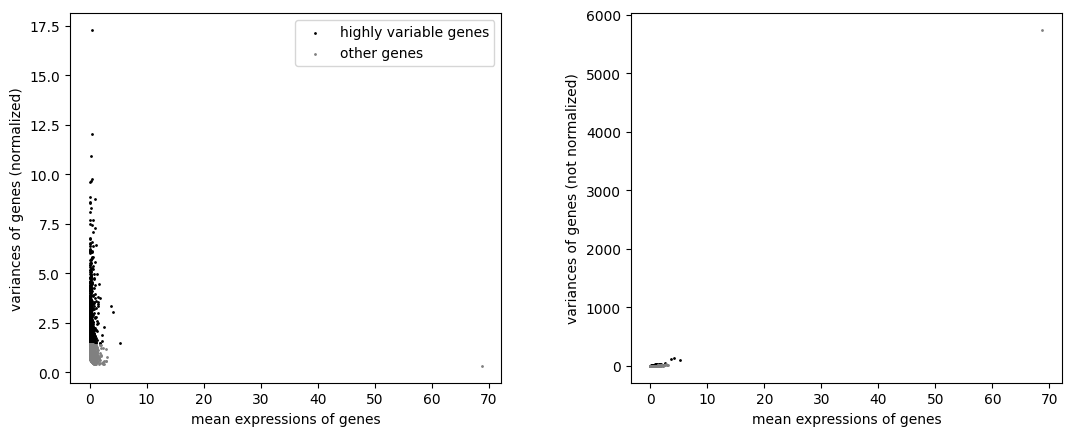

In [38]:
# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

In [39]:
adata.var.keys()

Index(['mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts',
       'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts',
       'log1p_total_counts', 'n_cells', 'highly_variable',
       'highly_variable_rank', 'means', 'variances', 'variances_norm'],
      dtype='object')

In [40]:
# Filter out non highly variable genes
adata = adata[:,adata.var.highly_variable]

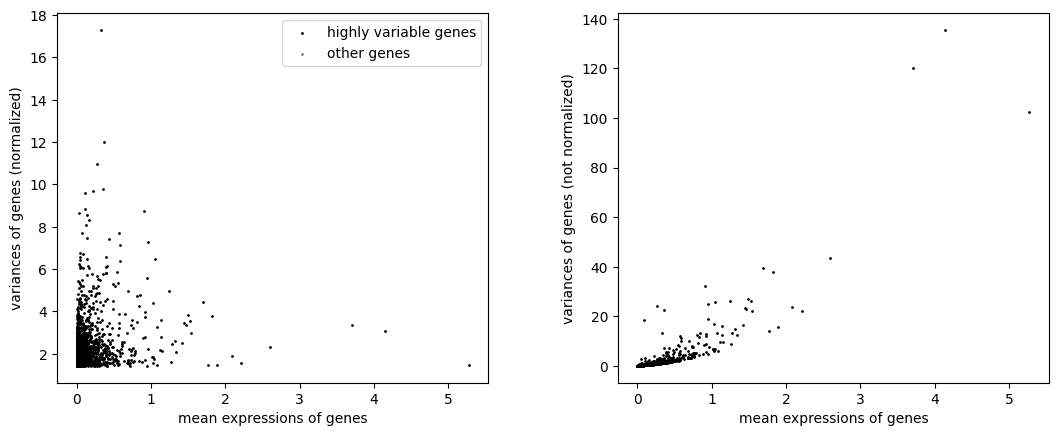

In [41]:
# Plot again
sc.pl.highly_variable_genes(adata)

In [42]:
adata

View of AnnData object with n_obs × n_vars = 6094 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'cat_outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cat_outlier_colors', 'hvg'
    layers: 'pearson_residuals'

# Dimensionality Reduction

Once we have subset our genes to the most informative subsets, we are still left with more genes than the human mind can easily comprehend. Additionally high dimensional data does not always mean informative data, much of the information we have on hand could be a product of noise and various other artifacts. This is where unsupervised machine learning methods such as clustering and dimensionality reduction come into play. These methods take the 2000+/- genes in our data and without any labels to inform grouping (unsupervised) they apply various statistical methods to reduce the number of dimensions to a handful of informative dimensions. 

As always various methods exist and are continuesly refined. Some default apporaches include:
- `Principle Component Analysis (PCA)`: Finds linear combinations of features that maximaize variance and groups them into sets of principle components.
    - An old method but still widely used
    - Excellent for reducing dimensinality for downstream workflows. 
    - Not great with visualization
- `Stochastic Neighbor Embedding (tSNE)`: Uses pair wise similarties to reduce the dimensionaity of data
    - Can be computationally expensive for large datasets
- `Uniform Manifold Approximation and Projection (UMAP)`: Applies k-nearest neighbors approach to high dimensional data. 
    - Highly stable and does an excelent job at seperating cell types

In [43]:
# Swap normalized values for raw counts
adata.X = adata.layers["pearson_residuals"]

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\anndata\_core\anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\Owner\AppData\Local\Temp\ipykernel_9300\789186299.py:2: UserWarning: Trying to set a dense array with a sparse array on a view.Densifying the sparse array.This may incur excessive memory usage
  adata.X = adata.layers["pearson_residuals"]


In [44]:
adata.X

ArrayView([[ 1.6983762 , -0.15655157,  4.668026  , ..., 10.422582  ,
             6.8307977 ,  6.0292506 ],
           [-0.45663056, -0.15475783, -0.564263  , ..., -1.5995715 ,
            -1.6869764 , -2.1738813 ],
           [ 6.420597  , -0.14797738, 10.547181  , ..., -1.5311533 ,
             6.2244687 , -1.6235528 ],
           ...,
           [-0.0829989 , -0.02810425, -0.1026172 , ..., -0.29411224,
            -0.31062603,  2.0666702 ],
           [-0.08249129, -0.02793236, -0.10198964, ..., -0.29231492,
            -0.30872798, -0.40160787],
           [-0.08310004, -0.0281385 , -0.10274225, ..., -0.29447037,
            -0.31100422, -0.40456694]], dtype=float32)

In [45]:
# Apply PCA 
sc.pp.pca(adata, svd_solver="arpack", mask_var="highly_variable")
adata

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


AnnData object with n_obs × n_vars = 6094 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'cat_outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cat_outlier_colors', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'pearson_residuals'

We note that we have included additional variables into our Anndata object after running PCA. Specifically we have the default addition of 50 Priniciple Components. 

In [46]:
adata.uns["pca"]

{'params': {'zero_center': True,
  'use_highly_variable': True,
  'mask_var': 'highly_variable'},
 'variance': array([283.03204  , 178.62442  , 140.20583  , 133.50293  , 106.21805  ,
         83.06967  ,  69.67251  ,  54.636093 ,  50.8885   ,  37.65496  ,
         36.45822  ,  35.85882  ,  35.173977 ,  34.834827 ,  31.565264 ,
         30.821032 ,  28.679476 ,  23.69105  ,  22.874329 ,  22.4794   ,
         19.534155 ,  18.5403   ,  16.26657  ,  14.9233   ,  14.414799 ,
         13.457214 ,  13.355783 ,  12.499587 ,  12.16938  ,  11.414747 ,
         10.969795 ,  10.79018  ,  10.624054 ,  10.400861 ,  10.233585 ,
          9.848738 ,   9.485737 ,   9.377984 ,   9.332142 ,   9.257043 ,
          9.060901 ,   8.935359 ,   8.407982 ,   8.328678 ,   8.190908 ,
          7.939572 ,   7.7864103,   7.681416 ,   7.491899 ,   7.455703 ],
       dtype=float32),
 'variance_ratio': array([0.06003298, 0.03788743, 0.02973859, 0.02831686, 0.02252955,
        0.01761963, 0.014778  , 0.01158868, 0.0107

We can use a variance ratio plot (aka: elbow plot) to visualize the impact of each PC on the variance of the data. The Y-Axis denotes the amount of variance that the given X value describes. This plot can be used to identify the number of PC's that provide meaningful insight into the data, this is done by identifying the elbox joint in the plot (the point in the plot where additional PC's do not account for much more variability in the data). In the spirit of permissive filtering, it is accepted practice to slightly overshoot the elbow point. In the plot below, i might select anywhere from 10-12 PC's to move forward with the analysis. 

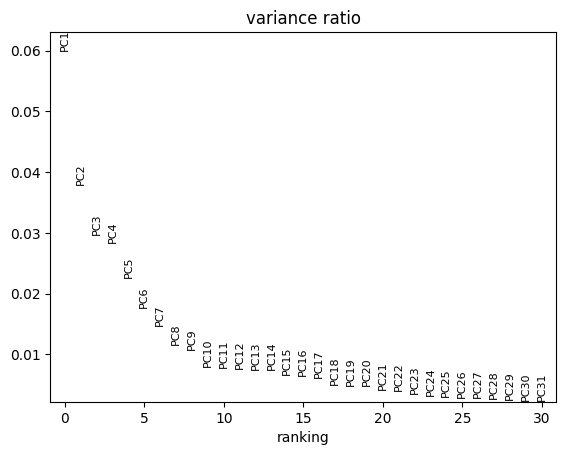

In [47]:
# Plot elbow curve
sc.pl.pca_variance_ratio(adata)

Additionally we can inspect the PCA loadings to determine the genes and their linear combinations that are influencing our first few PC's. 

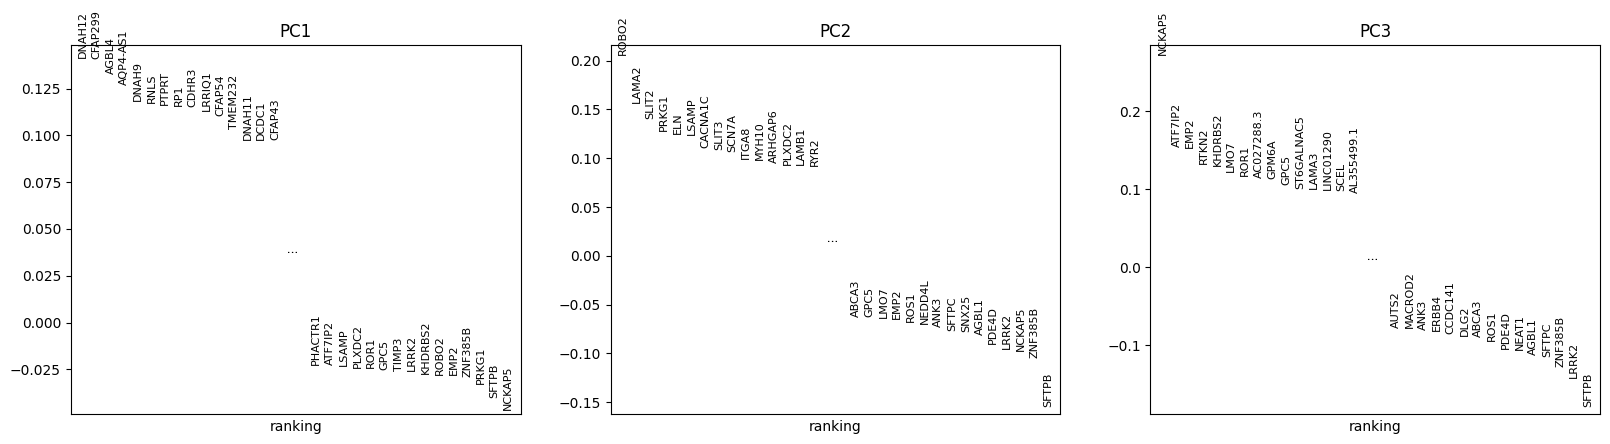

In [48]:
sc.pl.pca_loadings(adata)

Lastly we can plot the first two PC's (or any others) to visualize how well the cells are groups. (this result is generally not very informative)

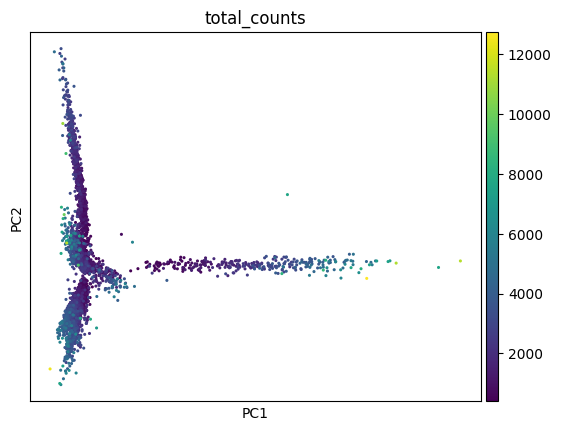

In [49]:
# Visualize
sc.pl.pca_scatter(adata, color="total_counts")

In [50]:
# Apply tSNE
sc.tl.tsne(adata, use_rep="X_pca")
adata

AnnData object with n_obs × n_vars = 6094 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'cat_outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cat_outlier_colors', 'hvg', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'pearson_residuals'

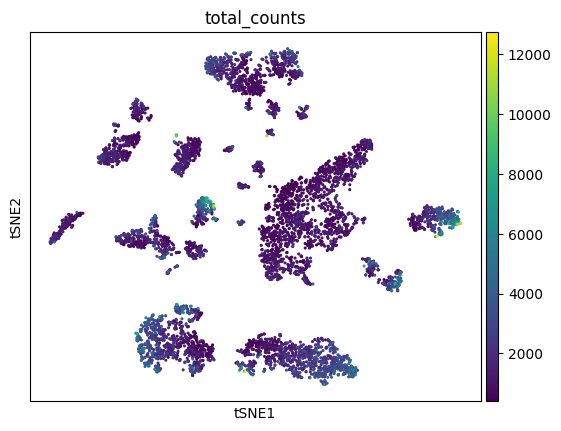

In [51]:
# Visualize tSNE
sc.pl.tsne(adata, color="total_counts")

In [52]:
# UMAP
sc.pp.neighbors(adata, n_pcs=12)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 6094 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'cat_outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cat_outlier_colors', 'hvg', 'pca', 'tsne', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'pearson_residuals'
    obsp: 'distances', 'connectivities'

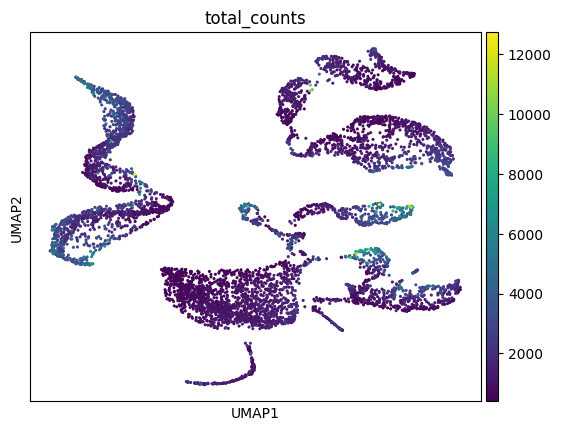

In [53]:
# Plot
sc.pl.umap(adata, color="total_counts")

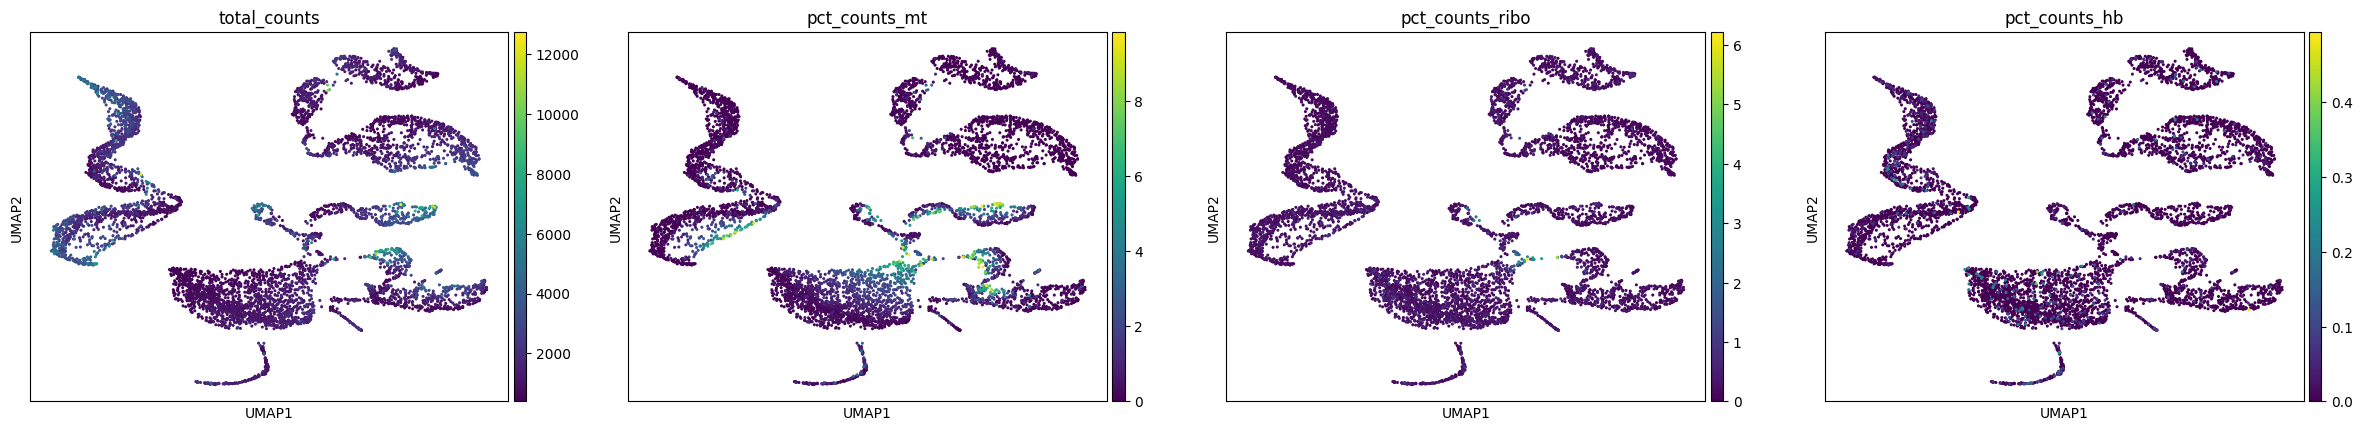

In [54]:
# Inspect quality control 
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
)

## Cell Clusters

In order to computationally determine the cluster assignments, we utlize Leiden clustering. [From Louvain to Leiden: guaranteeing well-connected communities](https://www.nature.com/articles/s41598-019-41695-z). Leiden clustering uses K Nearest Neighbores (KNN) method to groups cells based on a predefined (but meaningless) resolution metric (default is 1.0, higher values product more clusters). This requires some refinement and can be further optimized by increasing the resolution of a subcluster. 

In [55]:
# Call Leiden algoritm with various resolutions that are saved into out Anndata object
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)
adata

C:\Users\Owner\AppData\Local\Temp\ipykernel_9300\1506171588.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)


AnnData object with n_obs × n_vars = 6094 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'cat_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cat_outlier_colors', 'hvg', 'pca', 'tsne', 'neighbors', 'umap', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'pearson_residuals'
    obsp: 'distances', 'connectivities'

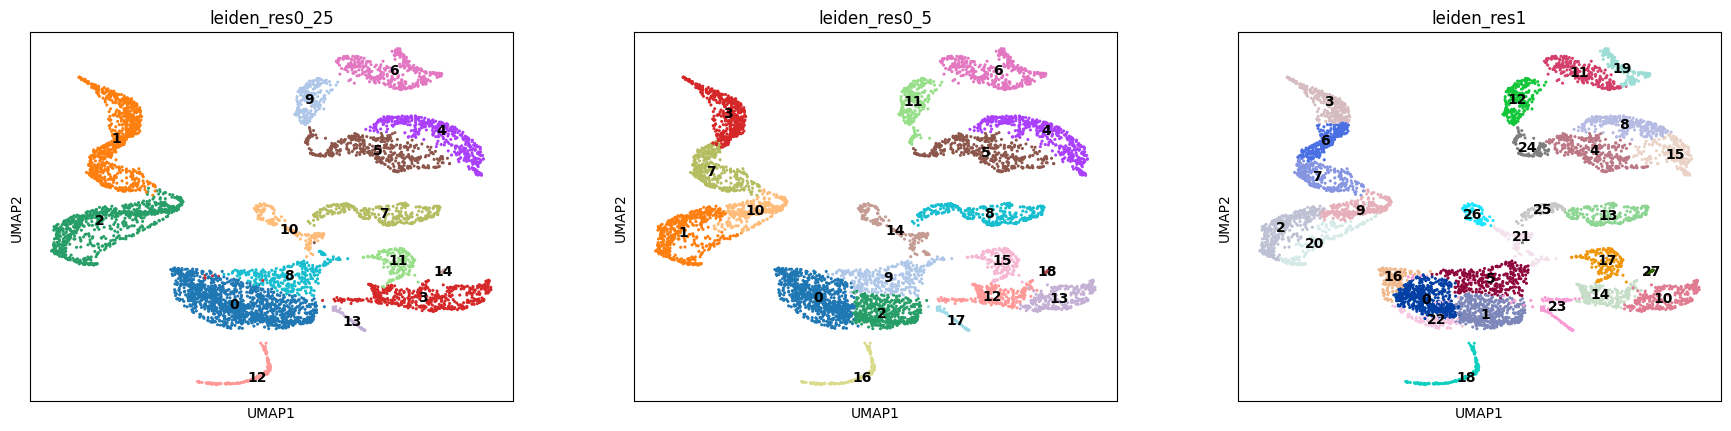

In [56]:
# Visualize outputs
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

# Pipeline

Now that we have developed a structure for importing, cleaning, normalizing and clustering a single patient sample, we will draft a pipeline to perform the same workflow on the ramaining samples in the original dataset. In the end we want to obtain a single Anndata object that contains all the cells from the 26 patient sample. This tast is expected to be computationally expensive and may require cloud computing services or high powered CPU's and/or GPU's in our personal computers. 

Once we have a singular Anndata object, we will confirm that the integration of the patient samples looks good, save out Anndata object and move foreward to idenitifying and annotating our cell types. 

In [114]:
def Process_and_integrate(csv_dir):
    import anndata
    adata_list = []  # Initialize a list to store AnnData objects
    
    
    for file in os.listdir(csv_dir):
        file_path = os.path.join(csv_dir, file)
        if file.endswith('.csv'): 
            adata = sc.read_csv(file_path).T
            sample_name = file.split("_")[1]  
            adata.obs["Sample"] = sample_name
            print(f"{sample_name} has {adata.X.shape[0]} cells and {adata.X.shape[1]} transcripts")

            # Annotate mitochondrial, ribosomal, and hemoglobin genes
            adata.var["mt"] = adata.var_names.str.startswith("MT-")
            adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
            adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

            # Calculate QC metrics
            sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

            # Remove outliers
            adata.obs["outlier"] = (
                    is_outlier(adata, "log1p_total_counts", 5)
                    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
            )
            print(adata.obs.outlier.value_counts())
            adata = adata[(~adata.obs.outlier)].copy()

            # Filter zero-variance genes
            sc.pp.filter_genes(adata, min_cells=1)
            sc.pp.filter_genes(adata, min_counts=1)

            # Normalize with Pearson residuals
            analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
            adata.layers["pearson_residuals"] = csr_matrix(analytic_pearson["X"])

            # Filter zero-variance genes
            sc.pp.filter_genes(adata, min_cells=1)
            sc.pp.filter_genes(adata, min_counts=1)

            # Identify highly variable genes
            sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3', subset=True)

            print(f"{sample_name} has been processed\n")
            adata_list.append(adata)  # Add processed AnnData object to list
    
    # Concatenate objects
    combined_adata = anndata.concat(
        adata_list,
        merge='same', 
        label='Sample',
        keys=[ad.obs['Sample'][0] for ad in adata_list]
    )
    return combined_adata


In [115]:
combined_adata = Process_and_integrate("data/GSE171524_RAW/csv")

C51ctr has 6099 cells and 34546 transcripts
outlier
False    6094
True        5
Name: count, dtype: int64
C51ctr has been processed

C52ctr has 4513 cells and 34546 transcripts
outlier
False    4513
Name: count, dtype: int64
C52ctr has been processed

C53ctr has 7120 cells and 34546 transcripts
outlier
False    7113
True        7
Name: count, dtype: int64
C53ctr has been processed

C54ctr has 4382 cells and 34546 transcripts
outlier
False    4378
True        4
Name: count, dtype: int64
C54ctr has been processed

C55ctr has 5685 cells and 34546 transcripts
outlier
False    5673
True       12
Name: count, dtype: int64
C55ctr has been processed

C56ctr has 4090 cells and 34546 transcripts
outlier
False    4081
True        9
Name: count, dtype: int64
C56ctr has been processed

C57ctr has 4789 cells and 34546 transcripts
outlier
False    4776
True       13
Name: count, dtype: int64
C57ctr has been processed

L01cov has 3060 cells and 34546 transcripts
outlier
False    3053
True        7
Nam

ValueError: b'reciprocal condition number  1.6102e-14'

In [116]:
combined_adata

AnnData object with n_obs × n_vars = 116145 × 143
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'highly_variable'
    layers: 'pearson_residuals'

# Annotations

Finally we arrive at the argueble most difficult portion of our analysis. Interpreting the data into biologically relevant cell types. 

Like essentially every step along the way, this is a highly itterative step that requires domain knowledge or a cleaver application of key resources. 

Much like sanding a 3D printed object or a wood carving, its generally a good idea to start with coarse identification of cell types and transition towards more fine grained annotations such as activation states and subpopulations. An ideal starting place is to determine commonly known cell types such as B-Cells and T-Cells, which are normally well defined in clustering outputs and have unique gene signatures that can easily differentiate them. 

# Conclusions

## Discoveries

explain

## Future Directions

explain

# End

## Show Session Information

In [57]:
import session_info
session_info.show()

## Save Session Requirements

In [58]:
# Replace spaces in notebook title with underscores
filename = Notebook_title.replace(" ", "_") + "_requirements.txt"

# Run the pip freeze command and save the output txt file
!pip freeze > $filename